In [3]:
import os
import math
import cv2
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Delaunay
from shapely.geometry import MultiPoint, LineString, MultiLineString
from shapely.ops import polygonize, unary_union


def alpha_shape(points, alpha):
    if len(points) < 4:
        return MultiPoint(list(points)).convex_hull
    tri = Delaunay(points)
    edges = set()
    for ia, ib, ic in tri.simplices:
        pa, pb, pc = points[ia], points[ib], points[ic]
        a, b, c = np.linalg.norm(pb - pa), np.linalg.norm(pc - pb), np.linalg.norm(pa - pc)
        s = (a + b + c) / 2.0
        area = math.sqrt(max(s * (s - a) * (s - b) * (s - c), 0))
        if area == 0:
            continue
        circum_r = a * b * c / (4.0 * area)
        if circum_r < 1.0 / alpha:
            edges.update([(ia, ib), (ib, ic), (ic, ia)])
    edge_points = [LineString([points[i], points[j]]) for i, j in edges]
    m = MultiLineString(edge_points)
    return unary_union(list(polygonize(m)))


def load_gaze_data(base_path):
    gaze_data_per_viewer = []
    mat_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if f.endswith('.mat')]
    for mat_file in mat_files:
        mat = scipy.io.loadmat(mat_file)
        eyetrack = mat['eyetrackRecord']
        gaze_x = eyetrack['x'][0, 0].flatten()
        gaze_y = eyetrack['y'][0, 0].flatten()
        timestamps = eyetrack['t'][0, 0].flatten()
        valid = (gaze_x != -32768) & (gaze_y != -32768)
        gaze_x = gaze_x[valid]
        gaze_y = gaze_y[valid]
        timestamps = timestamps[valid] - timestamps[0]
        gaze_x_norm = gaze_x / np.max(gaze_x)
        gaze_y_norm = gaze_y / np.max(gaze_y)
        gaze_data_per_viewer.append((gaze_x_norm, gaze_y_norm, timestamps))
    return gaze_data_per_viewer


def run_hull_analysis_plot(base_path, video_path, alpha=0.03, window_size=20):
    gaze_data_per_viewer = load_gaze_data(base_path)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("❌ Cannot open video.")
        return None

    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frame_numbers = []
    convex_areas = []
    concave_areas = []

    frame_num = 0
    while cap.isOpened():
        ret, _ = cap.read()
        if not ret:
            break

        gaze_points = []
        for gaze_x_norm, gaze_y_norm, timestamps in gaze_data_per_viewer:
            frame_indices = (timestamps / 1000 * fps).astype(int)
            if frame_num in frame_indices:
                idx = np.where(frame_indices == frame_num)[0]
                for i in idx:
                    gx = int(np.clip(gaze_x_norm[i], 0, 1) * (w - 1))
                    gy = int(np.clip(gaze_y_norm[i], 0, 1) * (h - 1))
                    gaze_points.append((gx, gy))

        if len(gaze_points) >= 3:
            points = np.array(gaze_points)
            try:
                convex_area = ConvexHull(points).volume
            except:
                convex_area = 0
            try:
                concave = alpha_shape(points, alpha)
                concave_area = concave.area if concave and concave.geom_type == 'Polygon' else 0
            except:
                concave_area = 0

            frame_numbers.append(frame_num)
            convex_areas.append(convex_area)
            concave_areas.append(concave_area)

        frame_num += 1

    cap.release()

    # === Plotting ===
    df = pd.DataFrame({
        'Frame': frame_numbers,
        'Convex Area': convex_areas,
        'Concave Area': concave_areas
    })
    df.set_index('Frame', inplace=True)
    df['Convex Area (Rolling Avg)'] = df['Convex Area'].rolling(window=window_size, min_periods=1).mean()
    df['Concave Area (Rolling Avg)'] = df['Concave Area'].rolling(window=window_size, min_periods=1).mean()
    df['Score'] = (df['Convex Area (Rolling Avg)'] - df['Concave Area (Rolling Avg)']) / df['Convex Area (Rolling Avg)']
    df['Score'] = df['Score'].fillna(0)

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Convex Area'], alpha=0.3, label='Convex Area (Raw)', color='green')
    plt.plot(df.index, df['Concave Area'], alpha=0.3, label='Concave Area (Raw)', color='blue')
    plt.plot(df.index, df['Convex Area (Rolling Avg)'], label=f'Convex Area (Avg, w={window_size})', color='darkgreen', linewidth=2)
    plt.plot(df.index, df['Concave Area (Rolling Avg)'], label=f'Concave Area (Avg, w={window_size})', color='navy', linewidth=2)
    plt.xlabel("Frame Number")
    plt.ylabel("Area (px²)")
    plt.title("Convex vs Concave Hull Area Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def run_video_with_gaze_and_hulls(base_path, video_path, alpha=0.03):
    gaze_data_per_viewer = load_gaze_data(base_path)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("❌ Cannot open video.")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frame_num = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gaze_points = []
        for gaze_x_norm, gaze_y_norm, timestamps in gaze_data_per_viewer:
            frame_indices = (timestamps / 1000 * fps).astype(int)
            if frame_num in frame_indices:
                idx = np.where(frame_indices == frame_num)[0]
                for i in idx:
                    gx = int(np.clip(gaze_x_norm[i], 0, 1) * (w - 1))
                    gy = int(np.clip(gaze_y_norm[i], 0, 1) * (h - 1))
                    gaze_points.append((gx, gy))
                    cv2.circle(frame, (gx, gy), 4, (0, 0, 255), -1)

        if len(gaze_points) >= 3:
            points = np.array(gaze_points)
            try:
                hull = ConvexHull(points)
                hull_pts = points[hull.vertices].reshape((-1, 1, 2))
                cv2.polylines(frame, [hull_pts], isClosed=True, color=(0, 255, 0), thickness=2)
            except:
                pass
            try:
                concave = alpha_shape(points, alpha)
                if concave and concave.geom_type == 'Polygon':
                    exterior = np.array(concave.exterior.coords).astype(np.int32)
                    cv2.polylines(frame, [exterior.reshape((-1, 1, 2))], isClosed=True, color=(255, 215, 0), thickness=2)
            except:
                pass

        cv2.imshow("Gaze + Hulls", frame)
        if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
            break

        frame_num += 1

    cap.release()
    cv2.destroyAllWindows()


In [4]:
if __name__ == "__main__":
    base_path = "/Users/joesrwt/Desktop/info visual/joe/clips_folder/SIMPS_9a"
    video_path = "/Users/joesrwt/Desktop/info visual/joe/Clips (small size)/SIMPS_9a_c.mov"

    # 👇 To run video viewer with gaze points and hulls
    run_video_with_gaze_and_hulls(base_path, video_path, alpha=0.007)


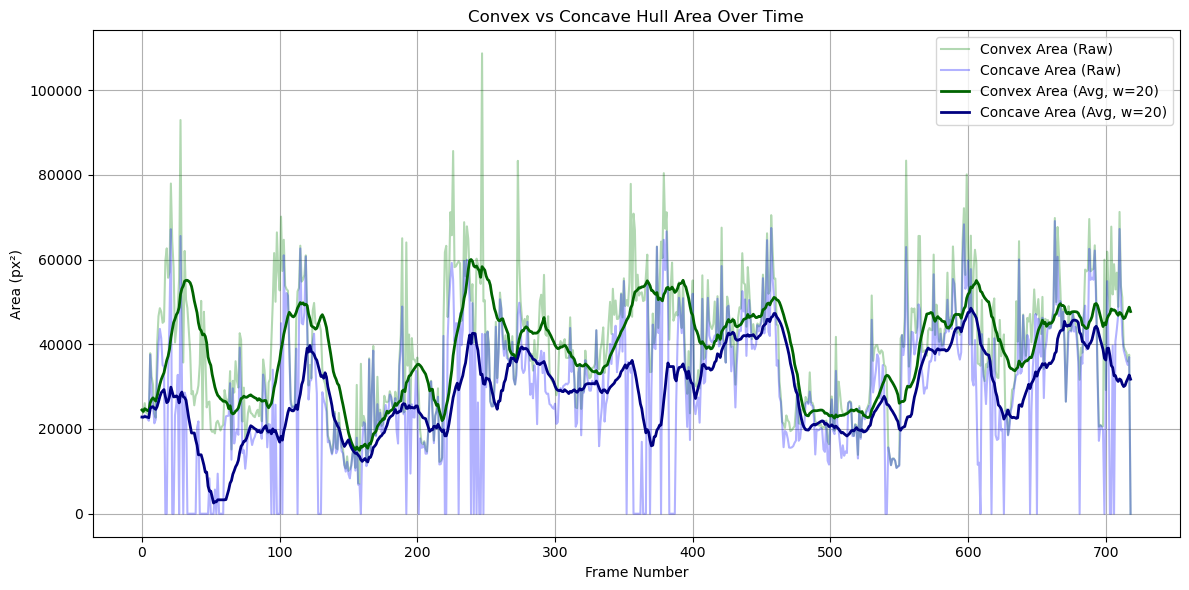

In [5]:
if __name__ == "__main__":
    base_path = "/Users/joesrwt/Desktop/info visual/joe/clips_folder/SIMPS_9a"
    video_path = "/Users/joesrwt/Desktop/info visual/joe/Clips (small size)/SIMPS_9a_c.mov"

    # 👇 To generate and view the full plot directly
    run_hull_analysis_plot(base_path, video_path, alpha=0.007, window_size=20)


In [ ]:
base_path = "/Users/joesrwt/Desktop/info visual/joe/clips_folder/SIMPS_9a"
video_path = "/Users/joesrwt/Desktop/info visual/joe/Clips (small size)/SIMPS_9a_c.mov"

base_path = "/Users/joesrwt/Desktop/info visual/joe/clips_folder/SIMPS_9a"
video_path = "/Users/joesrwt/Desktop/info visual/joe/Clips (small size)/SIMPS_9a_c.mov"

